In [6]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset
from transformers import BertTokenizer
from torch.utils.data import Dataset, DataLoader, random_split
import torch
torch.manual_seed(0)
class CustomDataset(Dataset):
    def __init__(self, csv_file, label_encoders):
        self.data = pd.read_csv(csv_file)
        self.data = self.data[:].dropna()
        self.text = self.data['review'].tolist()
        self.target1 = self.data['drug'].tolist()
        self.target2 = self.data['condition'].tolist()
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        # Retrieve label encoders from the provided dictionary
        self.label_encoder1 = label_encoders['target1']
        self.label_encoder2 = label_encoders['target2']

        # Encode target variables using the retrieved label encoders
        self.target1_encoded = self.label_encoder1.transform(self.target1)
        self.target2_encoded = self.label_encoder2.transform(self.target2)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.text[idx]
        target1 = self.target1_encoded[idx]
        target2 = self.target2_encoded[idx]

        # Tokenize the text
        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=512,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': inputs['input_ids'].squeeze(0),
            'attention_mask': inputs['attention_mask'].squeeze(0),
            'target1': target1,
            'target2': target2,
            'original_target1': self.target1[idx],
            'original_target2': self.target2[idx]
        }

# Example usage:
csv_file_train = r'/Data/df_train_20.csv'  
csv_file_test = r"/Data/df_test_20_final.csv"

# Create label encoders for target variables
label_encoders = {}
label_encoders['target1'] = LabelEncoder()
label_encoders['target2'] = LabelEncoder()

# Fit label encoders on target variables
# data = pd.read_csv(csv_file_test)
data_train = pd.read_csv(csv_file_train)
label_encoders['target1'].fit(data_train['drug'])
label_encoders['target2'].fit(data_train['condition'])

# Create dataset with label encoders
dataset = CustomDataset(csv_file_test, label_encoders)


In [7]:
test_dataloader = DataLoader(dataset, batch_size=4, shuffle=False)

In [8]:
import torch
import torch.nn as nn
from transformers import BertModel

class BertClassifier(nn.Module):
    def __init__(self, num_classes1, num_classes2):
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(self.bert.config.hidden_size, num_classes1)
        self.fc2 = nn.Linear(self.bert.config.hidden_size, num_classes2)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        pooled_output = self.dropout(outputs.pooler_output)

        # Use pooled_output for final classification
        logits1 = self.fc1(pooled_output)
        logits2 = self.fc2(pooled_output)

        return logits1, logits2

# Example usage:
num_classes1 = len(label_encoders['target1'].classes_)
num_classes2 = len(label_encoders['target2'].classes_)
model = BertClassifier(num_classes1, num_classes2)


In [9]:
# import torch
# Load the saved model state dictionary
model_path = r"./mymodel.pth"
model.load_state_dict(torch.load(model_path))
print("Model loaded successfully!")

Model loaded successfully!


In [10]:
from tqdm import tqdm

def inference(model, dataloader, label_encoders, device):
    model = model.to(device)
    model.eval()
    all_preds1 = []
    all_preds2 = []
    all_targets1 = []
    all_targets2 = []

    for batch in tqdm(dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        target1 = batch['target1'].to(device)
        target2 = batch['target2'].to(device)

        logits1, logits2 = model(input_ids, attention_mask)

        all_preds1.extend(logits1.argmax(dim=1).cpu().numpy())
        all_preds2.extend(logits2.argmax(dim=1).cpu().numpy())
        all_targets1.extend(target1.cpu().numpy())
        all_targets2.extend(target2.cpu().numpy())

    # Reverse label encoding
    label_encoder1 = label_encoders['target1']
    label_encoder2 = label_encoders['target2']
    original_preds1 = label_encoder1.inverse_transform(all_preds1)
    original_preds2 = label_encoder2.inverse_transform(all_preds2)
    original_targets1 = label_encoder1.inverse_transform(all_targets1)
    original_targets2 = label_encoder2.inverse_transform(all_targets2)

    return original_preds1, original_preds2, original_targets1, original_targets2


# Perform inference
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
preds1, preds2, targets1, targets2 = inference(model, test_dataloader, label_encoders, device)

# Analysis of predictions
for pred1, pred2, target1, target2 in zip(preds1, preds2, targets1, targets2):
    print(f'Predicted target1: {pred1}, Original target1: {target1}')
    print(f'Predicted target2: {pred2}, Original target2: {target2}')
    print()  # Add a newline for readability


  0%|          | 0/5779 [00:00<?, ?it/s]

100%|██████████| 5779/5779 [06:22<00:00, 15.10it/s]


Predicted target1: Etonogestrel, Original target1: Mirtazapine
Predicted target2: Birth Control, Original target2: Depression

Predicted target1: Etonogestrel, Original target1: sulfamethoxazole, trimethoprim 
Predicted target2: Birth Control, Original target2: Urinary Tract Infection

Predicted target1: Etonogestrel, Original target1: Copper
Predicted target2: Birth Control, Original target2: Birth Control

Predicted target1: Etonogestrel, Original target1: levonorgestrel, ethinyl estradiol
Predicted target2: Birth Control, Original target2: Birth Control

Predicted target1: Etonogestrel, Original target1: Miconazole
Predicted target2: Birth Control, Original target2: Vaginal Yeast Infection

Predicted target1: Etonogestrel, Original target1: Zolpidem
Predicted target2: Birth Control, Original target2: Insomnia

Predicted target1: Etonogestrel, Original target1: Ciprofloxacin
Predicted target2: Birth Control, Original target2: Urinary Tract Infection

Predicted target1: Etonogestrel, 

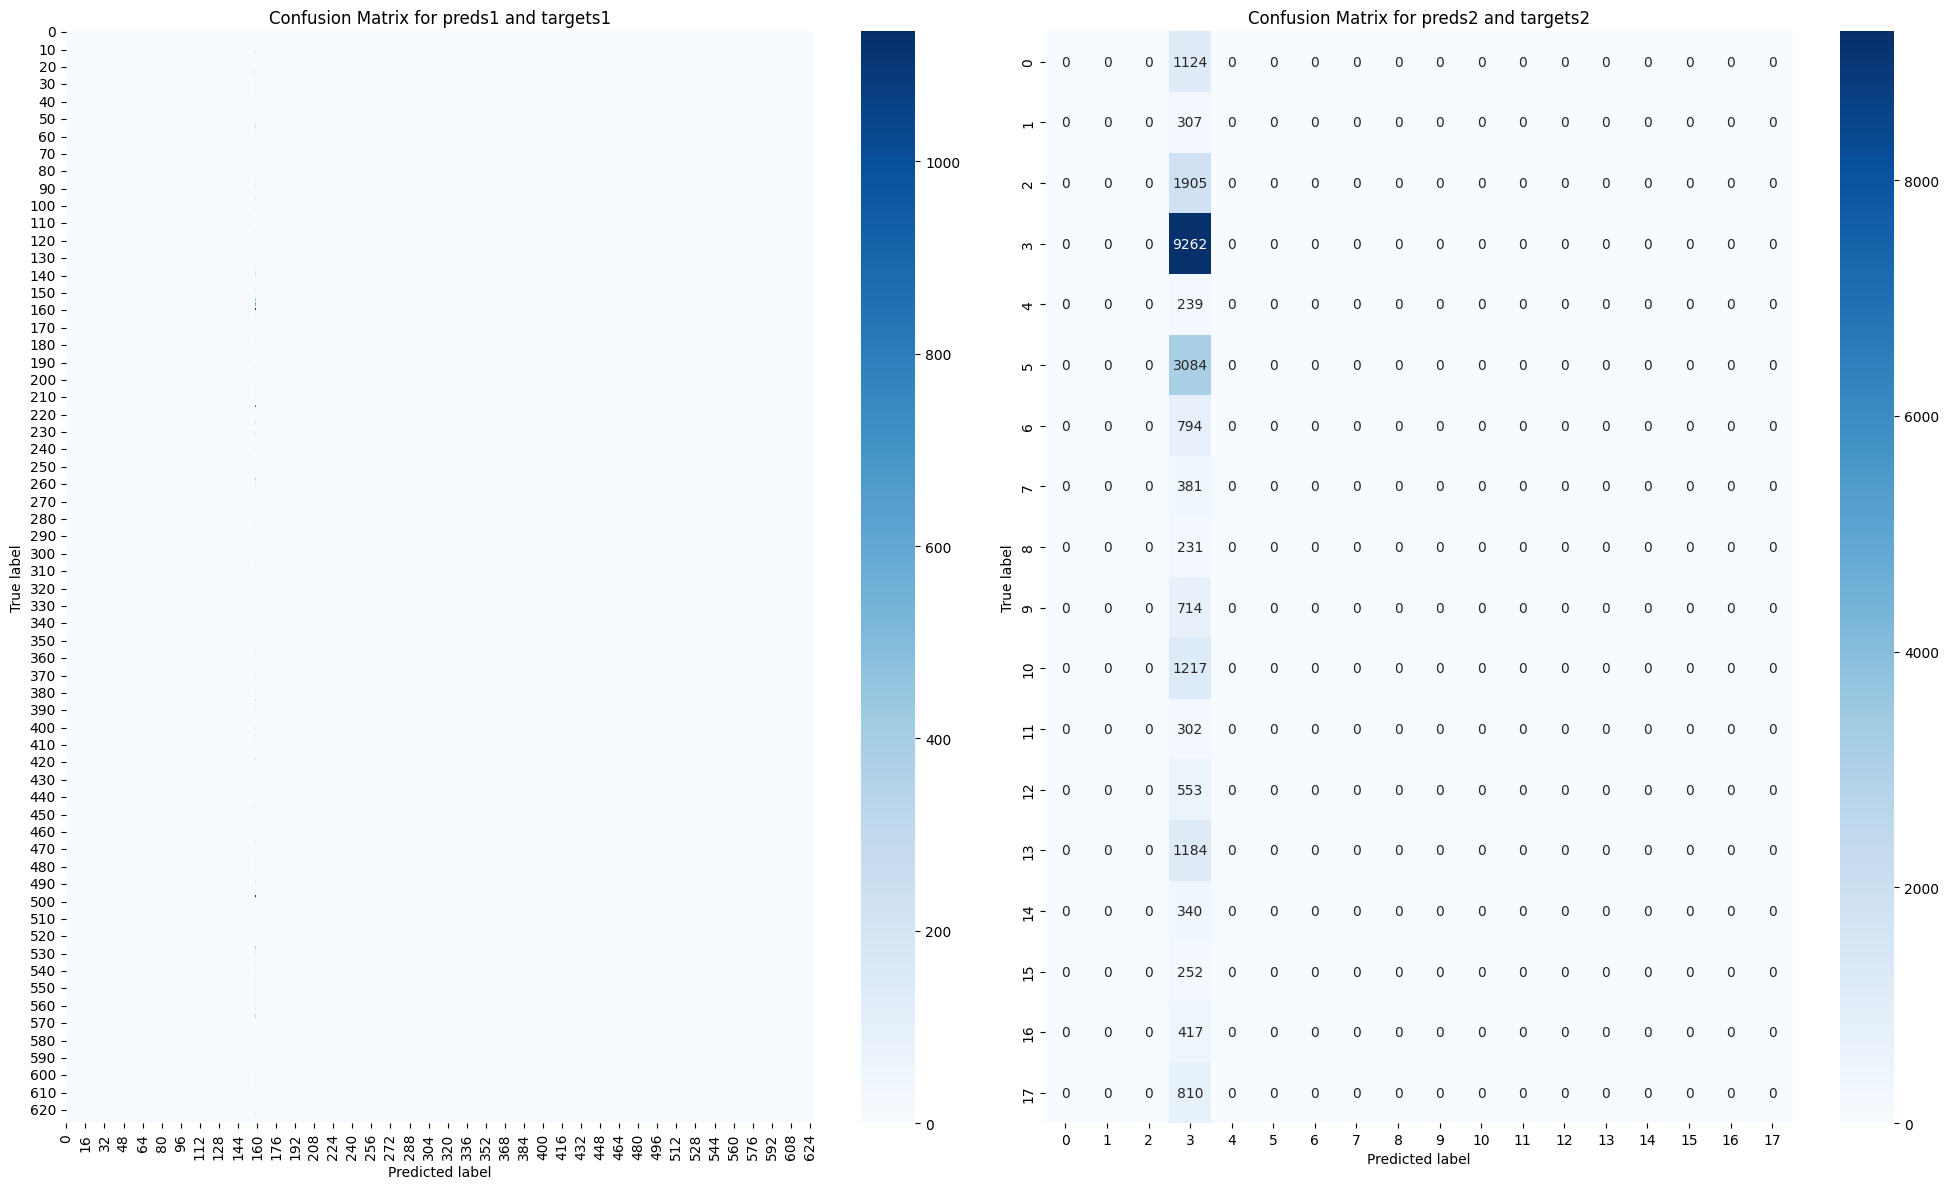

For preds1 and targets1:
Accuracy: 0.046720885966430176
F1 Score: 0.00014215120044056343
Confusion Matrix:
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

For preds2 and targets2:
Accuracy: 0.40067485724173735
F1 Score: 0.03178427052662645
Confusion Matrix:
 [[   0    0    0 1124    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]
 [   0    0    0  307    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]
 [   0    0    0 1905    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]
 [   0    0    0 9262    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]
 [   0    0    0  239    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]
 [   0    0    0 3084    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]
 [   0    0    0  794    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]
 [

In [11]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Assuming preds1, preds2, targets1, and targets2 are your prediction and target arrays/lists
import seaborn as sns
import matplotlib.pyplot as plt
# Calculate accuracy
accuracy_1 = accuracy_score(targets1, preds1)
accuracy_2 = accuracy_score(targets2, preds2)

# Calculate F1 score
f1_score_1 = f1_score(targets1, preds1,average="macro")
f1_score_2 = f1_score(targets2, preds2,average="macro")

# Calculate confusion matrix
conf_matrix_1 = confusion_matrix(targets1, preds1)
conf_matrix_2 = confusion_matrix(targets2, preds2)

plt.figure(figsize=(20, 12))

plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_1, fmt='d', cmap='Blues')
plt.title("Confusion Matrix for preds1 and targets1")
plt.xlabel("Predicted label")
plt.ylabel("True label")

plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_2,annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix for preds2 and targets2")
plt.xlabel("Predicted label")
plt.ylabel("True label")

plt.tight_layout()
plt.show()

print("For preds1 and targets1:")
print("Accuracy:", accuracy_1)
print("F1 Score:", f1_score_1)
print("Confusion Matrix:\n", conf_matrix_1)

print("\nFor preds2 and targets2:")
print("Accuracy:", accuracy_2)
print("F1 Score:", f1_score_2)
print("Confusion Matrix:\n", conf_matrix_2)


In [14]:
# Assuming targets1 contains drug names and targets2 contains disease names

# Create an empty dictionary to store drugs for each disease
disease_drugs_map = {}

# Populate the dictionary
for disease, drug in zip(targets2, targets1):
    if disease in disease_drugs_map:
        disease_drugs_map[disease].append(drug)
    else:
        disease_drugs_map[disease] = [drug]

# Print the list of drugs corresponding to each disease
for disease, drugs in disease_drugs_map.items():
    print(f"Disease: {disease}")
    print("Drugs:", drugs)


Disease: Depression
Drugs: ['Mirtazapine', 'Escitalopram', 'sertraline', 'venlafaxine ', 'Venlafaxine', 'Venlafaxine', 'Bupropion', 'Bupropion', 'sertraline', 'Escitalopram', 'venlafaxine ', 'Desvenlafaxine', 'Sertraline', 'desvenlafaxine', 'Vilazodone', 'Bupropion', 'escitalopram ', 'Venlafaxine', 'sertraline', 'Desvenlafaxine', 'Vilazodone ', 'nefazodone', 'sertraline', 'escitalopram ', 'vortioxetine', 'Bupropion', 'Mirtazapine', 'Citalopram', 'bupropion ', 'Desvenlafaxine', 'Tramadol', 'bupropion ', 'levomilnacipran ', 'Bupropion', 'Vilazodone ', 'Alprazolam ', 'Vilazodone ', 'Citalopram', 'Duloxetine', 'bupropion ', 'citalopram ', 'Sertraline', 'sertraline', 'Sertraline', 'sertraline', 'citalopram ', 'Mirtazapine', 'sertraline', 'Venlafaxine', 'citalopram ', 'Venlafaxine', 'Desvenlafaxine', 'bupropion ', 'desvenlafaxine', 'bupropion ', 'Duloxetine', 'Bupropion', 'Vilazodone ', 'Doxepin', 'armodafinil', 'Vortioxetine', 'Desvenlafaxine', 'Duloxetine', 'Risperidone', 'Citalopram', 'Bu

: 

In [8]:
disease_drugs_map

{'Depression': ['Mirtazapine',
  'Escitalopram',
  'sertraline',
  'venlafaxine ',
  'Venlafaxine',
  'Venlafaxine',
  'Bupropion',
  'Bupropion',
  'sertraline',
  'Escitalopram',
  'venlafaxine ',
  'Desvenlafaxine',
  'Sertraline',
  'desvenlafaxine',
  'Vilazodone',
  'Bupropion',
  'escitalopram ',
  'Venlafaxine',
  'sertraline',
  'Desvenlafaxine',
  'Vilazodone ',
  'nefazodone',
  'sertraline',
  'escitalopram ',
  'vortioxetine',
  'Bupropion',
  'Mirtazapine',
  'Citalopram',
  'bupropion ',
  'Desvenlafaxine',
  'Tramadol',
  'bupropion ',
  'levomilnacipran ',
  'Bupropion',
  'Vilazodone ',
  'Alprazolam ',
  'Vilazodone ',
  'Citalopram',
  'Duloxetine',
  'bupropion ',
  'citalopram ',
  'Sertraline',
  'sertraline',
  'Sertraline',
  'sertraline',
  'citalopram ',
  'Mirtazapine',
  'sertraline',
  'Venlafaxine',
  'citalopram ',
  'Venlafaxine',
  'Desvenlafaxine',
  'bupropion ',
  'desvenlafaxine',
  'bupropion ',
  'Duloxetine',
  'Bupropion',
  'Vilazodone ',
  'D

In [8]:
# Populate the dictionary

# Calculate accuracy based on the mapping
total_correct = 0
total_samples = len(targets2)

for disease, drugs in zip(targets2,preds1):
    # Check if any predicted drug matches the disease
    
    if drugs in disease_drugs_map[disease]:
        total_correct += 1
    
    

# Calculate accuracy
accuracy = total_correct/total_samples

print("Accuracy: when disease is same --", accuracy)

Accuracy: when disease is same -- 0.40067485724173735
